## BME i9400
## Fall 2024
### Homework 5: Dropout regularization in MLPs and Convolutional Neural Networks

**Due date: Wednesday, December 11th 2024, 11:59 PM EST**

**Total points: 100**

## Instructions

In this homework you will familiarize yourself with a type of regularization that is commonly used in deep learning models: *dropout*.

Dropout is a regularization technique that aims to prevent overfitting by randomly “dropping out” (setting to zero) a subset of neurons and their connections during training. During each training iteration, a randomly selected subset of the neurons is temporarily removed from the network. By removing neurons, dropout forces the network to not rely too heavily on any one neuron, encouraging redundancy and robust feature learning.Note that during model evaluation, dropout is turned off, and all neurons are active, but their outputs are scaled by the dropout rate to maintain consistency with training.

Dropout mitigates overfitting by introducing noise into the training process, effectively training many smaller “sub-networks” and averaging their predictions. By training with multiple random sub-networks, the model becomes more robust and less sensitive to specific neurons or weights.

In PyTorch, dropout is implemented with the `nn.Dropout` module. The `nn.Dropout` module takes a single argument, `p`, which is the probability of dropping out a neuron. The `p` argument is the probability that a neuron will be zeroed out during training. The `p` argument is typically set to a value between 0.2 and 0.5.

To instantiate a dropout layer with a dropout rate of 0.2, you can use the following code:
```dropout_layer = nn.Dropout(p=0.2)```

To apply dropout to a tensor `x`, you can use the following code:
```x = dropout_layer(x)```


In [142]:
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

## Load the dataset, split into train and test sets, cast to PyTorch tensors, and create data loaders
(DONE FOR YOU)

In [143]:
tmp = np.load('eeg_alcohol_data.npy', allow_pickle=True)
X = tmp.item().get('X')
y = tmp.item().get('y')
if X.dtype != np.float32:
    X = np.array(X, dtype=np.float32)
if y.dtype not in [np.int32, np.int64]:
    y = np.array(y, dtype=np.int64)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Define the CNN model
We will work with a model that combines two convolutional layers at the front end with three fully connected layers at the back end. Pay attention to the arguments of the Conv2D and Linear blocks, as it will help your understanding of the model architecture.
(DONE FOR YOU)

In [144]:
class EEGCNN(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes):
        super(EEGCNN, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))  # Spatial filtering
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))  # Temporal filtering
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32) # fully connected layer 1
        self.fc2 = nn.Linear(32, 16)  # fully connected layer 2
        self.fc3 = nn.Linear(16, num_classes) # fully connected layer 3
        self.softmax = nn.Softmax(dim=1)

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x) # convert from 2D to 1D
        x = self.fc1(x) # fully connected layer 1
        x = self.fc2(x) # fully connected layer 2
        x = self.fc3(x) # fully connected layer 3
        x = self.softmax(x)

        return x

### Instantiate the model with the parameters of our dataset
(DONE FOR YOU)

In [145]:
input_channels = X_train.shape[1]  # 64 electrodes
input_timepoints = X_train.shape[2]  # 256 time samples
num_classes = len(torch.unique(y_train))  # Number of unique classes in y
model = EEGCNN(input_channels, input_timepoints, num_classes)

### Define the training loop and train for 200 epochs
Below is a function that trains the model for a specified number of epochs, reporting the training and test loss after each epoch.
(DONE FOR YOU)

In [146]:
def run_train_loop(model, criterion, optimizer, epochs=200):

    train_losses = []
    test_losses = []

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        for X_batch, y_batch in train_loader:
            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        # evaluate test loss
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for X_batch, y_batch in test_loader:
                outputs = model(X_batch)
                loss = criterion(outputs, y_batch)
                test_loss += loss.item()

        print(f"Epoch {epoch+1}/{epochs}, Loss: {running_loss/len(train_loader):.4f}, Test Loss: {test_loss/len(test_loader):.4f}")
        train_losses.append(running_loss/len(train_loader))
        test_losses.append(test_loss/len(test_loader))

    return train_losses, test_losses

### Here we train the model for 200 epochs
(DONE FOR YOU)

In [147]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
epochs = 200
train_losses, test_losses = run_train_loop(model, criterion, optimizer, epochs)

Epoch 1/200, Loss: 0.8191, Test Loss: 0.7885
Epoch 2/200, Loss: 0.7224, Test Loss: 0.7720
Epoch 3/200, Loss: 0.6368, Test Loss: 0.6283
Epoch 4/200, Loss: 0.5416, Test Loss: 0.5961
Epoch 5/200, Loss: 0.4764, Test Loss: 0.6002
Epoch 6/200, Loss: 0.4352, Test Loss: 0.5448
Epoch 7/200, Loss: 0.4084, Test Loss: 0.5619
Epoch 8/200, Loss: 0.3818, Test Loss: 0.5268
Epoch 9/200, Loss: 0.3615, Test Loss: 0.5570
Epoch 10/200, Loss: 0.3580, Test Loss: 0.6257
Epoch 11/200, Loss: 0.3636, Test Loss: 0.5857
Epoch 12/200, Loss: 0.3457, Test Loss: 0.5365
Epoch 13/200, Loss: 0.3472, Test Loss: 0.5745
Epoch 14/200, Loss: 0.3470, Test Loss: 0.5465
Epoch 15/200, Loss: 0.3354, Test Loss: 0.5655
Epoch 16/200, Loss: 0.3382, Test Loss: 0.5911
Epoch 17/200, Loss: 0.3397, Test Loss: 0.6009
Epoch 18/200, Loss: 0.3481, Test Loss: 0.5924
Epoch 19/200, Loss: 0.3340, Test Loss: 0.5527
Epoch 20/200, Loss: 0.3309, Test Loss: 0.5684
Epoch 21/200, Loss: 0.3271, Test Loss: 0.5666
Epoch 22/200, Loss: 0.3219, Test Loss: 0.57

## Task 1: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

Text(0.5, 1.0, 'Loss w/o Dropout')

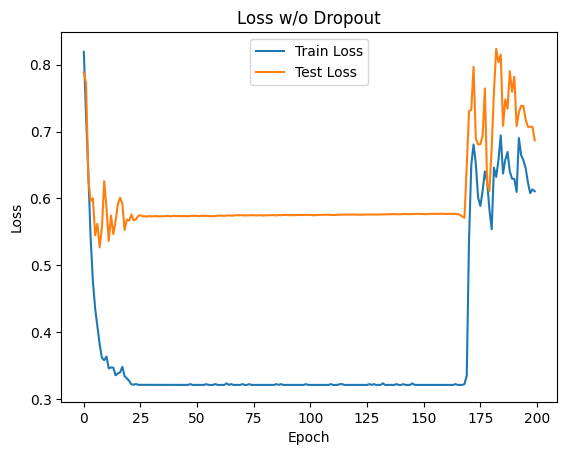

In [148]:
## INSERT CODE HERE
plt.figure()
plt.plot(train_losses,label = 'Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss w/o Dropout')

## Task 2: Compute the minimum train and test loss achieved during training and report them

In [149]:
## INSERT CODE HERE
test_loss_00 = min(test_losses)
train_loss_00 = min(train_losses)
print(f'Minimum Train Loss = {train_loss_00}')
print(f'Minimum Test Loss = {test_loss_00}')

Minimum Train Loss = 0.32107144097487134
Minimum Test Loss = 0.5268478989601135


## Task 3: Modify EEGCNN to add dropout regularization
- Modify the cell below to add **three** dropout layers to the EEGCNN model
    - The first dropout layer should be added after the flattening layer
    - The second dropout layer should be added after the first fully connected layer
    - The third dropout layer should be added after the second fully connected layer
- The dropout rates of each layer should be the same and should be passed as an argument to the model constructor
- The default dropout rate should be 0.2

In [150]:
class EEGCNNwithDropout(nn.Module):
    def __init__(self, input_channels, input_timepoints, num_classes, dropout=0.2):
        super(EEGCNNwithDropout, self).__init__()
        self.spatial_conv = nn.Conv2d(1, 8, kernel_size=(input_channels, 1))
        self.temporal_conv = nn.Conv2d(8, 16, kernel_size=(1, 10), stride=(1, 2))
        self.flatten = nn.Flatten()
        self.dropout = nn.Dropout(p=dropout)
        self.fc1 = nn.Linear(16 * ((input_timepoints - 10) // 2 + 1), 32)
        self.fc2 = nn.Linear(32, 16)
        self.fc3 = nn.Linear(16, num_classes)
        self.softmax = nn.Softmax(dim=1)
        # INSERT CODE BELOW

    def forward(self, x):
        x = x.unsqueeze(1)  # Add channel dimension
        x = torch.relu(self.spatial_conv(x))
        x = torch.relu(self.temporal_conv(x))
        x = self.flatten(x)
        # INSERT CODE BELOW
        x = self.dropout(x)
        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)
        x = self.fc3(x)
        x = self.softmax(x)

        return x

## Task 4: Train the EEGCNNwithDropout model with a dropout rate of 0.2 for 200 epochs
- Instantiate the model with a dropout rate of 0.2
- Train the model for 200 epochs

In [151]:
## INSERT CODE BELOW

model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.6709, Test Loss: 0.6357
Epoch 2/200, Loss: 0.6012, Test Loss: 0.6052
Epoch 3/200, Loss: 0.5230, Test Loss: 0.5857
Epoch 4/200, Loss: 0.4680, Test Loss: 0.6082
Epoch 5/200, Loss: 0.4471, Test Loss: 0.5416
Epoch 6/200, Loss: 0.4083, Test Loss: 0.5564
Epoch 7/200, Loss: 0.3939, Test Loss: 0.5515
Epoch 8/200, Loss: 0.3808, Test Loss: 0.5467
Epoch 9/200, Loss: 0.3760, Test Loss: 0.5413
Epoch 10/200, Loss: 0.3584, Test Loss: 0.5301
Epoch 11/200, Loss: 0.3464, Test Loss: 0.5317
Epoch 12/200, Loss: 0.3509, Test Loss: 0.5296
Epoch 13/200, Loss: 0.3644, Test Loss: 0.5260
Epoch 14/200, Loss: 0.3497, Test Loss: 0.5129
Epoch 15/200, Loss: 0.3833, Test Loss: 0.5507
Epoch 16/200, Loss: 0.3676, Test Loss: 0.5498
Epoch 17/200, Loss: 0.3578, Test Loss: 0.5481
Epoch 18/200, Loss: 0.3474, Test Loss: 0.5155
Epoch 19/200, Loss: 0.3320, Test Loss: 0.4845
Epoch 20/200, Loss: 0.3247, Test Loss: 0.4934
Epoch 21/200, Loss: 0.3210, Test Loss: 0.4835
Epoch 22/200, Loss: 0.3207, Test Loss: 0.47

## Task 5: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

Text(0.5, 1.0, 'Loss w/ Dropout = 0.2')

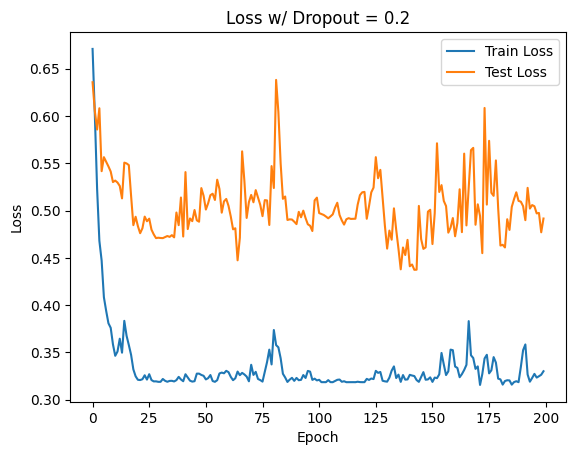

In [152]:
# INSERT CODE HERE
plt.figure()
plt.plot(train_losses,label = 'Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss w/ Dropout = 0.2')

## Task 6: Compute the minimum train and test loss achieved during training and report them

In [153]:
# INSERT CODE HERE
test_loss_02 = min(test_losses)
train_loss_02 = min(train_losses)
print(f'Minimum Train Loss = {train_loss_02}')
print(f'Minimum Test Loss = {test_loss_02}')

Minimum Train Loss = 0.31557411948839825
Minimum Test Loss = 0.4373203217983246


## Task 7: Train the EEGCNNwithDropout model with a dropout rate of 0.5 for 200 epochs

In [154]:
## INSERT CODE BELOW

model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.5)

## DO NOT MODIFY THE 3 LINES BELOW
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

Epoch 1/200, Loss: 0.7300, Test Loss: 0.7711
Epoch 2/200, Loss: 0.6973, Test Loss: 0.6559
Epoch 3/200, Loss: 0.6419, Test Loss: 0.6066
Epoch 4/200, Loss: 0.5763, Test Loss: 0.5901
Epoch 5/200, Loss: 0.5397, Test Loss: 0.5692
Epoch 6/200, Loss: 0.5058, Test Loss: 0.5568
Epoch 7/200, Loss: 0.4785, Test Loss: 0.5583
Epoch 8/200, Loss: 0.4582, Test Loss: 0.5589
Epoch 9/200, Loss: 0.4605, Test Loss: 0.5257
Epoch 10/200, Loss: 0.4328, Test Loss: 0.5503
Epoch 11/200, Loss: 0.4430, Test Loss: 0.5270
Epoch 12/200, Loss: 0.4311, Test Loss: 0.5035
Epoch 13/200, Loss: 0.3960, Test Loss: 0.4851
Epoch 14/200, Loss: 0.3996, Test Loss: 0.5022
Epoch 15/200, Loss: 0.3994, Test Loss: 0.5132
Epoch 16/200, Loss: 0.3924, Test Loss: 0.5174
Epoch 17/200, Loss: 0.3789, Test Loss: 0.4970
Epoch 18/200, Loss: 0.3789, Test Loss: 0.5159
Epoch 19/200, Loss: 0.3571, Test Loss: 0.5233
Epoch 20/200, Loss: 0.3710, Test Loss: 0.5181
Epoch 21/200, Loss: 0.3643, Test Loss: 0.5169
Epoch 22/200, Loss: 0.3841, Test Loss: 0.49

## Task 8: Plot the training and test loss (overlaid) on the vertical axis and the epoch number on the horizontal axis

Text(0.5, 1.0, 'Loss w/ Dropout = 0.5')

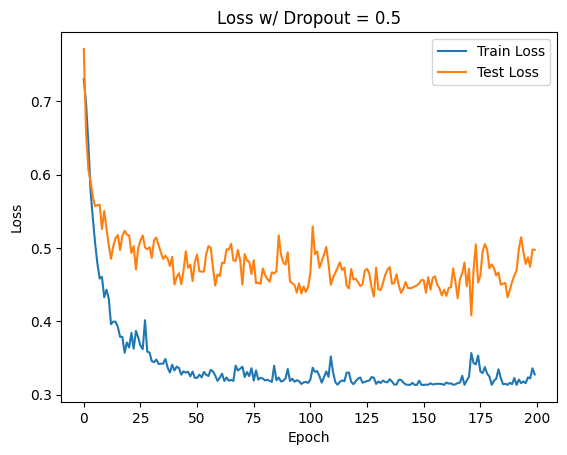

In [155]:
# INSERT CODE HERE
plt.figure()
plt.plot(train_losses,label = 'Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss w/ Dropout = 0.5')

## Task 9: Compute the minimum train and test loss achieved during training and report them

In [156]:
# INSERT CODE HERE
test_loss_05 = min(test_losses)
train_loss_05 = min(train_losses)
print(f'Minimum Train Loss = {train_loss_05}')
print(f'Minimum Test Loss = {test_loss_05}')


Minimum Train Loss = 0.31327561537424725
Minimum Test Loss = 0.40800488988558453


## Task 10: Repeat Tasks 7-9 for a dropout rate of 0.8
Report your observations. What do you notice about the train and test loss as the dropout rate increases?

Epoch 1/200, Loss: 0.7747, Test Loss: 0.6800
Epoch 2/200, Loss: 0.7540, Test Loss: 0.6727
Epoch 3/200, Loss: 0.7426, Test Loss: 0.6807
Epoch 4/200, Loss: 0.7256, Test Loss: 0.6707
Epoch 5/200, Loss: 0.7074, Test Loss: 0.6609
Epoch 6/200, Loss: 0.6995, Test Loss: 0.6585
Epoch 7/200, Loss: 0.7020, Test Loss: 0.6597
Epoch 8/200, Loss: 0.7116, Test Loss: 0.6587
Epoch 9/200, Loss: 0.6698, Test Loss: 0.6605
Epoch 10/200, Loss: 0.6882, Test Loss: 0.6539
Epoch 11/200, Loss: 0.6695, Test Loss: 0.6429
Epoch 12/200, Loss: 0.6523, Test Loss: 0.6276
Epoch 13/200, Loss: 0.6425, Test Loss: 0.6124
Epoch 14/200, Loss: 0.6068, Test Loss: 0.6106
Epoch 15/200, Loss: 0.5988, Test Loss: 0.5953
Epoch 16/200, Loss: 0.6101, Test Loss: 0.5844
Epoch 17/200, Loss: 0.6208, Test Loss: 0.5604
Epoch 18/200, Loss: 0.6067, Test Loss: 0.5572
Epoch 19/200, Loss: 0.5662, Test Loss: 0.5551
Epoch 20/200, Loss: 0.5577, Test Loss: 0.5370
Epoch 21/200, Loss: 0.5673, Test Loss: 0.5340
Epoch 22/200, Loss: 0.5396, Test Loss: 0.55

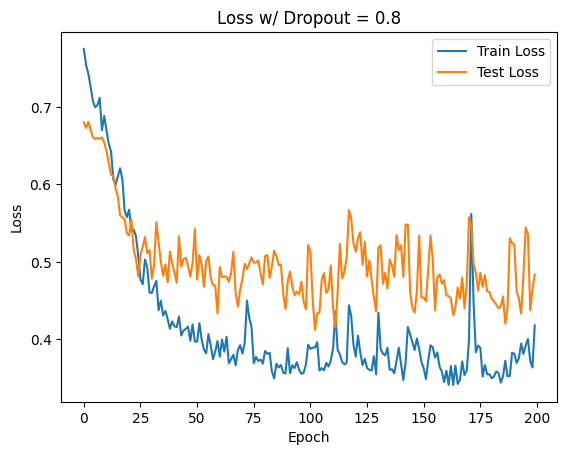

In [157]:
## INSERT CODE BELOW
model = EEGCNNwithDropout(input_channels, input_timepoints, num_classes, dropout=0.8)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
train_losses, test_losses = run_train_loop(model, criterion, optimizer, 200)

plt.figure()
plt.plot(train_losses,label = 'Train Loss')
plt.plot(test_losses,label='Test Loss')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss w/ Dropout = 0.8')
test_loss_08 = min(test_losses)
train_loss_08 = min(train_losses)
print(f'Minimum Train Loss = {train_loss_08}')
print(f'Minimum Test Loss = {test_loss_08}')

In [158]:
losses = {00:[test_loss_00,train_loss_00],0.2:[test_loss_02,train_loss_02],0.5:[test_loss_05,train_loss_05],0.8:[test_loss_08,train_loss_08]}
losses

##Based on the evidence, there seems to be a sweet-spot for dropout probability that results in the lowest test set loss, which is 0.5. Too much probability introduces too much noise and makes it very difficult to learn patterns. Too little and the model isn't as robust and may be subject to overfitting. More tweaking and fine-tuning can be used to find the best dropout rate.

{0: [0.5268478989601135, 0.32107144097487134],
 0.2: [0.4373203217983246, 0.31557411948839825],
 0.5: [0.40800488988558453, 0.31327561537424725],
 0.8: [0.4119544525941213, 0.34119663387537]}